<a href="https://colab.research.google.com/github/theabhinav0231/dive_into_deep_learning_book/blob/main/04_Linear_Neural_Networks_for_Classification(Image_Classification_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 686.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfu

In [31]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import time
from d2l import torch as d2l

In [2]:
d2l.use_svg_display()

## **Dataset**

In [3]:
class FashionMNIST(d2l.DataModule):
  def __init__(self, batch_size=64, resize=(28, 28)):
    super().__init__()
    self.save_hyperparameters()
    transform = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
    self.train = torchvision.datasets.FashionMNIST(root=self.root, train=True, transform=transform, download=True)
    self.val = torchvision.datasets.FashionMNIST(root=self.root, train=False, transform=transform, download=True)

In [4]:
data = FashionMNIST(resize=(32, 32))
len(data.train), len(data.val)

(60000, 10000)

In [5]:
data.train[0][0].shape

torch.Size([1, 32, 32])

In [6]:
@d2l.add_to_class(FashionMNIST)
def text_labels(self, indices):
  labels = ["t-shirt", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
  return [labels[int(i)] for i in indices]

In [7]:
@d2l.add_to_class(FashionMNIST)
def get_dataloader(self, train):
  data = self.train if train else self.val
  return torch.utils.data.DataLoader(data, self.batch_size, shuffle=True, num_workers=self.num_workers)

In [8]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([64, 1, 32, 32]) torch.float32 torch.Size([64]) torch.int64


In [9]:
tic = time.time()
for X, y in data.train_dataloader():
  continue
f"{time.time() - tic:.2f} sec(s)"

'20.34 sec(s)'

## **Visualization**

In [10]:
def show_images(image, num_rows, num_cols, title=None, scale=1.5):
  raise NotImplementedError

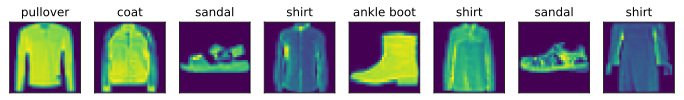

In [11]:
@d2l.add_to_class(FashionMNIST)
def visualize(self, batch, num_rows=1, num_cols=8, labels=[]):
  X, y = batch
  if not labels:
    labels = self.text_labels(y)
  d2l.show_images(X.squeeze(1), num_rows, num_cols, titles=labels)

batch = next(iter(data.train_dataloader()))
data.visualize(batch)

## **Bunch of useful function**

In [12]:
class Classifier(d2l.Module):
  def validation_step(self, batch):
    y_pred = self(*batch[:-1])
    self.plot("loss", self.loss(y_pred, batch[-1]), train=False)
    self.plot("accuracy", self.accuracy(y_pred, batch[-1]), train=False)

In [13]:
@d2l.add_to_class(d2l.Module)
def configure_parameters(self):
  return torch.optim.SGD(self.parameters(), lr=self.lr)

In [14]:
@d2l.add_to_class(Classifier)
def accuracy(self, y_pred, y, averaged=True):
  y_pred = y_pred.reshape((-1, y_pred.shape[-1]))
  preds = y_pred.argmax(axis=1).type(y.dtype)
  compare = (preds == y.reshape(-1)).type(torch.float32)
  return compare.mean() if averaged else compare

In [17]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1, keepdims=True)
  return X_exp / partition

## **Model**

In [16]:
class SoftmaxRegressionScratch(d2l.Classifier):
  def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    self.w = torch.normal(0, sigma, size=(num_inputs, num_outputs), requires_grad=True)
    self.b = torch.zeros(num_outputs, requires_grad=True)

  def parameters(self):
    return [self.w, self.b]

In [18]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
  X = X.reshape((-1, self.w.shape[0]))
  return softmax(torch.matmul(X, self.w) + self.b)

## **Loss Function (Negative Log-Likelihood)**

In [19]:
def cross_entropy(y_pred, y):
  return -torch.log(y_pred[list(range(len(y_pred))), y]).mean()

In [20]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_pred, y):
  return cross_entropy(y_pred, y)

## **Training**

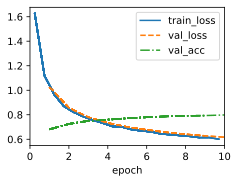

In [21]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.01)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## **Evaluation**

In [27]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape, preds

(torch.Size([256]),
 tensor([9, 2, 1, 1, 6, 1, 4, 6, 7, 7, 4, 5, 5, 3, 4, 1, 2, 6, 8, 0, 0, 7, 7, 5,
         1, 2, 4, 3, 9, 4, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 3, 9, 6, 9, 2, 1,
         4, 6, 6, 2, 7, 6, 4, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1, 3, 3, 7, 8, 7, 0,
         6, 6, 4, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 6, 5, 3, 6, 7, 1, 8,
         0, 1, 6, 2, 3, 4, 7, 2, 7, 8, 7, 9, 9, 4, 2, 5, 7, 0, 5, 2, 8, 4, 7, 8,
         0, 0, 9, 9, 3, 0, 8, 4, 1, 5, 4, 1, 9, 1, 8, 4, 6, 1, 2, 5, 1, 0, 0, 0,
         1, 6, 1, 3, 2, 2, 6, 6, 1, 3, 5, 0, 4, 7, 9, 3, 7, 2, 3, 9, 0, 9, 4, 7,
         4, 2, 0, 5, 4, 1, 2, 4, 3, 0, 9, 1, 0, 9, 3, 8, 7, 9, 9, 4, 4, 7, 1, 2,
         1, 2, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3,
         1, 2, 7, 4, 8, 5, 6, 0, 7, 7, 6, 6, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 4, 2,
         5, 4, 9, 4, 2, 8, 6, 4, 2, 4, 9, 7, 4, 5, 5, 4]))

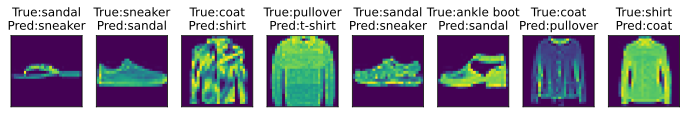

In [30]:
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = ["True:"+a+"\n"+"Pred:"+b for a, b in zip(data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)